# Chapter 5 - Resampling Methods

- [Load dataset](#Load-dataset)
- [Cross-Validation](#5.1-Cross-Validation)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
plt.style.use('seaborn-white')

### Load dataset Auto

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [4]:
# Get the data
import os

UP_DIR = '/Users/iordan/Documents/Statistics/Hunter/Data Science_STAT724/2020/data/'
csv_file = os.path.join(UP_DIR,'Auto.csv')

df1 = pd.read_csv(csv_file, header=0, squeeze=True, na_values='?').dropna()

In [5]:
#df1 = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


In [6]:
df1.shape

(392, 9)

## 5.1 Cross-Validation

### Figure 5.2 - Validation Set Approach
Using Polynomial feature generation in scikit-learn<BR>
http://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features

In [7]:
# np.ndenumerate?

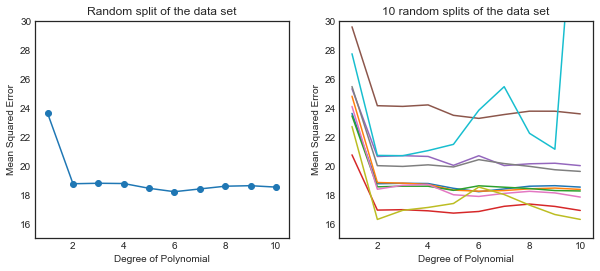

In [28]:
t_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df1.mpg.ravel(), test_size=t_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0],Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

### Figure 5.4

In [9]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df1)
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, df1.mpg, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

In [15]:
# np.zeros((p_order.size,r_state.size))
# Y


In [16]:
# k-fold CV
folds = 10
elements = len(df1.index)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds, shuffle=True) #random_state=Y[i,j])
    Z[i,j] = cross_val_score(regr, X_poly, df1.mpg, cv=kf_10, scoring='neg_mean_squared_error').mean()    

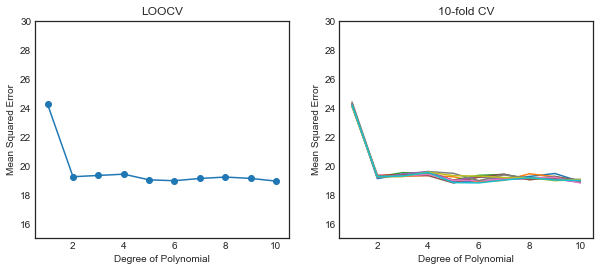

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Note: cross_val_score() method returns negative values for the scores.
# https://github.com/scikit-learn/scikit-learn/issues/2439

# Left plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV')

# Right plot
ax2.plot(X, Z*(-1))
ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

## Cross-validation and Other Sampling Used to Avoid Overfitting


The reason for train/test splits of data is always, at heart, a desire to avoid overfitting.  It is straightforward in supervised learning problems to fit a model against all the available data.  Since we, by definition, do not yet have the data we do not have, we want a proxy for "the novel data we might see in the future."

Obviously, the best proxy we can come up with is simply a portion of the original data that did not participate in the fitting of the model.  We rely on an assumption that our sample data is similar to observations we will obtain in the future.  However, there is really nothing better we might choose as such a proxy.

Using `train_test_split()` to divide the data between a training and testing set if a very reasonable approach.  By default, this utility function shuffles the data before splitting it; in general this will minimize effects related to order of collection or collation of the dataset.  However, especially on moderate sized datasets of hundreds or thousands of samples (but not really of tens of thousands, or millions), the particular accident of a randomized split can still lead to artifacts.

### Understanding splitting

`train_test_split()` performs just one split of a data array, while all the other splitting classes in `sklearn.model_selection` produce an iterator over multiple distinct splits.  

We will use the Iris dataset to illustrate these difference.  This dataset contains 150 observations of 3 different species of Iris, each sample containing 4 features.  It is a widely used example, and responds well to many classifiers.

In [18]:
from sklearn.model_selection import KFold, train_test_split
from sklearn import datasets

In order to show some different behavior of splitting techniques, we will modify the Iris data to drop some of it.  In particular, we truncate the last 25 observations.  The reason we do this is because the samples in the dataset are grouped by their class, first all the Iris setosa, then all the Iris virginica, and finally all the Iris versicolor samples.  The truncation will create an imbalance among the classes of observations.  Most datasets you will encountere will have varying numbers of samples in different classes.

In [19]:
iris = datasets.load_iris()
iris.data = iris.data[:-25]
iris.target = iris.target[:-25]
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


The basic utility function—as we have seen in prior lessons—simply divides the data into two arrays.  We keep the same number of columns as in the original, but put some of the rows in the first array and the rest in the second.

In [20]:
[arr.shape for arr in train_test_split(iris.data)]

[(93, 4), (32, 4)]

If more than one array is passed to the function, it will split each one in turn; the split will be consistent in choosing the corresponding rows from each array (which must, therefore, all have a consistent number of rows).

99% of the time, you use this behavior to simultaneously split features and target arrays.  In principle, the API of `train_test_split()` does nothing to enforce that usage.  In fact, in optionally taking more than two arguments, it is not constrained to this specific use.

In [21]:
import numpy as np
for arr in train_test_split(iris.data, iris.target, np.ones((125,3))):
    print(arr.shape)

(93, 4)
(32, 4)
(93,)
(32,)
(93, 3)
(32, 3)


### Multiple splitting

Classes for splitting create iterators over multiple splits using the same general algorithm for splitting.  

#### KFold

One of the simplest such techniques is `KFold`.  This simply divides the data into multiple "folds."  By default, `KFold` does not shuffle the data first; therefore, if the dataset is meaningfully ordered in some manner already, the folds may have importantly different characteristics.  

The potential differences among the folds can be good or bad, depending on your purpose.  Either way, be aware of it.  If you hope your model will generalize to sample collections with a characteristic not in the training, there is an advantage to not shuffling.  However, it equivalently means that a particular loop through fitting may not have the opportuntity to fit to data with that characteristic.

<img src="KFold.png" width="66%"/>

Below we loop through a three-way split of the (truncated) Iris data.  The lengths of the the training versus testing data are slightly different between iterations simply because 125 is not divisible by 3.

In [22]:
for n, (train, test) in enumerate(KFold(n_splits=3).split(iris.data)):
    print("Iteration: %d; Train shape: %s; Test shape: %s" % (n, train.shape, test.shape))

Iteration: 0; Train shape: (83,); Test shape: (42,)
Iteration: 1; Train shape: (83,); Test shape: (42,)
Iteration: 2; Train shape: (84,); Test shape: (41,)


One thing that might be surprising at first is that the shape of training arrays are not, e.g. `(83, 4)`.  What we iterate over is a collections of index positions into the underlying NumPy arrays.  So, for example, in the first iteration, the test data is the first 1/3rd of the rows in the data.

In [23]:
train, test = next(KFold(n_splits=3).split(iris.data))
print(test)
pd.DataFrame(iris.data[test], columns=iris.feature_names).tail()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
37,4.9,3.6,1.4,0.1
38,4.4,3.0,1.3,0.2
39,5.1,3.4,1.5,0.2
40,5.0,3.5,1.3,0.3
41,4.5,2.3,1.3,0.3


### StratifiedKFold

This cross-validation object is a variation of `KFold` that returns stratified folds. The folds are made by <u>preserving the percentage of samples for each class</u>.  Because this split is sensitive to the classes of the target, it must take a `y` argument to the `.split()` method.

In [24]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3).split(iris.data, iris.target)
for n, (train, test) in enumerate(skf):
    print("Iteration: %d; Train shape: %s; Test shape: %s" % (
                       n, train.shape, test.shape))

Iteration: 0; Train shape: (82,); Test shape: (43,)
Iteration: 1; Train shape: (83,); Test shape: (42,)
Iteration: 2; Train shape: (85,); Test shape: (40,)


Notice that the index positions generated for the first split are not successive from the head.  Rather there are 17 each from the first and second 50 samples, then 9 more from the last 25 samples.  Other folds are similar, with rounding producing slightly different counts.

In [25]:
skf = StratifiedKFold(n_splits=3).split(iris.data, iris.target)
train, test = next(skf)
print(test)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66 100 101
 102 103 104 105 106 107 108]


### LeaveOneOut

This splitting technique utilizes the maximum possible size for each training set which still creating a nominal testing set.  This can be useful to train models as completely as possible while still allowing validation.  Of course, this iterates over a number of splits equal to the number of samples, so is the most computationally spendy split possible also.

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut().split(iris.data)

In [ ]:
all_folds = []
for n, (train, test) in enumerate(loo):
    all_folds.append((n, train, test))

n, train, test = all_folds[0]
print("Iteration: %d; Train shape: %s; Test shape: %s; Test index: %s" % (
    n, train.shape, test.shape, test))
print("...")
n, train, test = all_folds[-1]
print("Iteration: %d; Train shape: %s; Test shape: %s; Test index: %s" % (
    n, train.shape, test.shape, test))

### GroupKFold

A `KFold` variant with non-overlapping groups.  The same group will not appear in two different folds (the number of distinct groups has to be at least equal to the number of folds).

The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [31]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=3).split(iris.data, groups=iris.target)
for n, (train, test) in enumerate(gkf):
    print("Iteration: %d; Train shape: %s; Test shape: %s" % (
                       n, train.shape, test.shape))

Iteration: 0; Train shape: (75,); Test shape: (50,)
Iteration: 1; Train shape: (75,); Test shape: (50,)
Iteration: 2; Train shape: (100,); Test shape: (25,)


In [32]:
# Verify that the final test group really is a homogeneous class
print("Index postitions:", test)
print("Species:", [iris.target_names[n] for n in iris.target[test]])

Index postitions: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124]
Species: ['virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica']


## Cross validation

The splitters discussed in this lesson are only a few of those in scikit-learn.  A variety of others build on the general idea contained in those discussed.  Consult the [documentation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for details on each.

The point of all these splitters is almost universally to be used in conjunction with cross validation.  The function `cross_val_score()` performs repeated training and scoring relative to muliple train/test splits. 

In [29]:
# As we mentioned, the Iris dataset is quite easy to fit
from sklearn.model_selection import cross_val_score
#from sklearn.svm import SVC
#clf = SVC(kernel='linear', C=1)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf = QDA()
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
scores                                              

array([1.  , 1.  , 0.96, 0.96, 1.  ])

If an integer argument is given for `cv`, as above, it performs a Stratified KFold with that number of folds.  But we can also give an iterable like one of the scorers discussed.  

The "score" given for each iteration is that produced by the `.score()` method of the estimator being used.  You can manually specify a different `scorer=my_scorer` parameter to `cross_val_score` if you want to use a different metric.

This is an artificially bad splitting strategy.  We train exclusively on two species on each iteration, then try to predict the excluded species.

In [33]:
cross_val_score(clf, iris.data, iris.target, 
                cv=GroupKFold(n_splits=3), groups=iris.target)

array([0., 0., 0.])

A less bad split for this particular dataset and classifier would be a basic KFold.  The data has an unequal number of samples from each class (by construction) and is orderd by class.  So this gets enough overlap to do well on some splits, but does poorly on others.

In generally, Stratified KFold is pretty robust, and hence is the default strategy used by `cross_val_score`.

In [34]:
cross_val_score(clf, iris.data, iris.target, cv=KFold(n_splits=3))

array([1.        , 0.88095238, 0.3902439 ])

In [35]:
loo_cv = cross_val_score(clf, iris.data, iris.target, cv=LeaveOneOut())
print("Mean leave-one-out cross validation:", np.mean(loo_cv))
print("All scores:\n", loo_cv)

Mean leave-one-out cross validation: 0.984
All scores:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
